In [38]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import t
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'

# file_name = 'combined_stock_data.csv'
# file_path = os.path.join(path, file_name)
# df = pd.read_csv(file_path)
# df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)
path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'
file_name = 'combined_stock_data.csv'
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path)

In [91]:
# #summary stats
# # print(df.describe())
# print(df.describe)
# print(df['industry'].unique())
# print(df['stock_market_cap'].describe)

# non_zero_dividends = df[df['dividends'] != 0]

# # Count the unique stocks in the filtered DataFrame
# unique_stocks_count = non_zero_dividends['ticker'].unique()

# print(unique_stocks_count)

# print(non_zero_dividends.describe())
# print(list(df.columns))
# print(df.dtypes)
# non_zero_count = (df['stock_volume'] != 0).sum()



62359


In [108]:
# negative_prices = df[df['stock_adj_close'] < 0]
# print(negative_prices)
# negative_prices = df[df['stock_close'] < 0]
# print(negative_prices)
filtered_df = df[df['industry'] == 'shell_companies']

# Display the stock prices for these companies
print(filtered_df[['stock_adj_close']].describe())

       stock_adj_close
count     1.643000e+03
mean      9.137720e+00
std       2.148803e+01
min       1.000000e-06
25%       3.500000e-03
50%       1.000000e-02
75%       1.833330e-01
max       7.625000e+01


In [53]:



df['date'] = pd.to_datetime(df['date'])


df['stock_return'] = df.groupby('ticker')['stock_adj_close'].pct_change()
df['market_return'] = df['market_adj_close'].pct_change()


event_date = datetime(2018, 6, 28)
window_start = event_date - timedelta(days=5)
window_end = event_date + timedelta(days=5)


event_window_data = df[(df['date'] >= window_start) & (df['date'] <= window_end)]


def estimate_parameters(ticker, data):
    stock_data = data[data['ticker'] == ticker].dropna()
    if len(stock_data) < 2: 
        return np.nan, np.nan
    X = sm.add_constant(stock_data['market_return'])
    model = sm.OLS(stock_data['stock_return'], X).fit()
    return model.params


parameters = {ticker: estimate_parameters(ticker, df) for ticker in df['ticker'].unique()}


def calculate_expected_return(row, params):
    alpha, beta = params.get(row['ticker'], (np.nan, np.nan))
    if pd.isna(alpha) or pd.isna(beta):  
        return np.nan
    return alpha + beta * row['market_return']

event_window_data['expected_return'] = event_window_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)


event_window_data['abnormal_return'] = event_window_data['stock_return'] - event_window_data['expected_return']


event_window_data[['date', 'ticker', 'stock_return', 'market_return', 'expected_return', 'abnormal_return']]


C:\Users\Janet\AppData\Local\Temp\ipykernel_29312\3300613522.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window_data['expected_return'] = event_window_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)
C:\Users\Janet\AppData\Local\Temp\ipykernel_29312\3300613522.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window_data['abnormal_return'] = event_window_data['stock_return'] - event_window_data['expected_return']


,date,ticker,stock_return,market_return,expected_return,abnormal_return
60099,2018-06-25,SAYFF,0.000000,-0.013725,0.000286,-0.000286
60100,2018-06-25,FRRFF,0.000000,0.000000,0.000480,-0.000480
60101,2018-06-25,ABM,-0.011483,0.000000,-0.001061,-0.010422
60102,2018-06-25,ACN,-0.021738,0.000000,0.001251,-0.022988
60103,2018-06-25,AHEXF,-0.017753,0.000000,-0.000672,-0.017080
...,...,...,...,...,...,...
61852,2018-07-03,APVS,0.000000,0.000000,0.001591,-0.001591
61853,2018-07-03,ASFT,0.000000,0.000000,-0.005463,0.005463
61854,2018-07-03,APCX,0.000000,0.000000,0.016838,-0.016838
61855,2018-07-03,APYP,0.000000,0.000000,0.012976,-0.012976


In [74]:
path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'
file_name = 'combined_stock_data.csv'
file_path = os.path.join(path, file_name)
stock_data = pd.read_csv(file_path)

# Event date
event_date = datetime(2018, 6, 28)

# Define the event window (e.g., 10 days before and after the event)
window_size = 10
start_date = event_date - timedelta(days=window_size)
end_date = event_date + timedelta(days=window_size)

# Filter data for the event window
event_window_data = stock_data[(pd.to_datetime(stock_data['date']) >= start_date) & 
                               (pd.to_datetime(stock_data['date']) <= end_date)]

# Estimation window (e.g., 30 days before the start of the event window)
estimation_window_size = 30
estimation_start_date = start_date - timedelta(days=estimation_window_size)
estimation_end_date = start_date - timedelta(days=1)

# Filter data for the estimation window
estimation_window_data = stock_data[(pd.to_datetime(stock_data['date']) >= estimation_start_date) & 
                                    (pd.to_datetime(stock_data['date']) <= estimation_end_date)]

# Calculate average volume in the estimation window for comparison
average_volume_estimation = estimation_window_data.groupby('ticker')['stock_volume'].mean()

# Merge this average with the event window data
event_window_data = event_window_data.join(average_volume_estimation, on='ticker', rsuffix='_avg')

# Calculate the difference in volume
event_window_data['volume_difference'] = event_window_data['stock_volume'] - event_window_data['stock_volume_avg']

# Display the event window data with the calculated differences
event_window_data[['date', 'ticker', 'stock_volume', 'stock_volume_avg', 'volume_difference']]


,date,ticker,stock_volume,stock_volume_avg,volume_difference
58847,2018-06-18,SAYFF,0,1.500000e+01,-1.500000e+01
58848,2018-06-18,FRRFF,0,0.000000e+00,0.000000e+00
58849,2018-06-18,ABM,795900,1.241600e+06,-4.457000e+05
58850,2018-06-18,ACN,1789800,2.254995e+06,-4.651947e+05
58851,2018-06-18,AHEXF,0,3.157895e+01,-3.157895e+01
...,...,...,...,...,...
62354,2018-07-06,APVS,0,4.613053e+03,-4.613053e+03
62355,2018-07-06,ASFT,0,5.263158e+00,-5.263158e+00
62356,2018-07-06,APCX,0,4.631579e+02,-4.631579e+02
62357,2018-07-06,APYP,1000000,2.301045e+06,-1.301045e+06


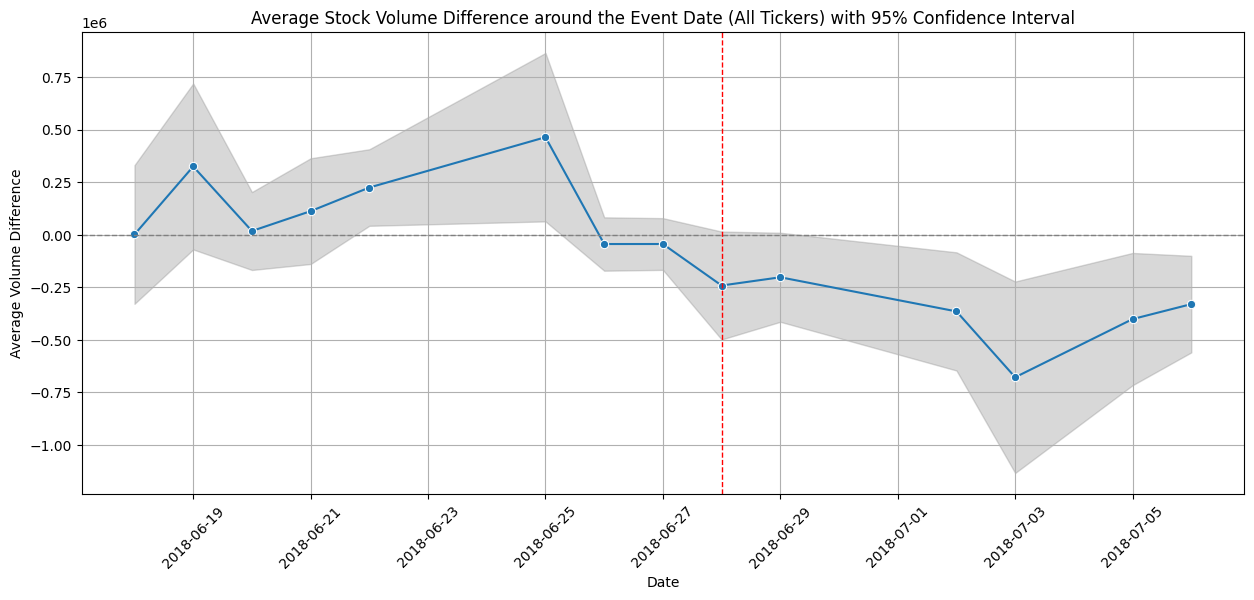

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the event window data by date and calculate the average volume difference for each date
grouped_data = event_window_data.groupby('date')['volume_difference']
mean_volume_difference = grouped_data.mean()
std_volume_difference = grouped_data.std()

# Calculate the number of observations per group for the confidence interval
n_per_group = grouped_data.count()

# Calculate the standard error of the mean
sem_volume_difference = std_volume_difference / np.sqrt(n_per_group)

# Confidence interval (95%)
ci = 1.96 * sem_volume_difference

# Add upper and lower confidence interval bounds to the mean data
mean_volume_difference = mean_volume_difference.to_frame('mean')
mean_volume_difference['lower_ci'] = mean_volume_difference['mean'] - ci
mean_volume_difference['upper_ci'] = mean_volume_difference['mean'] + ci

# Plotting
plt.figure(figsize=(15, 6))
plt.fill_between(mean_volume_difference.index, mean_volume_difference['lower_ci'], mean_volume_difference['upper_ci'], color='gray', alpha=0.3)
sns.lineplot(data=mean_volume_difference, x=mean_volume_difference.index, y='mean', marker='o')
plt.axhline(0, color='gray', lw=1, ls='--')  # Zero line for reference
plt.axvline(event_date, color='red', lw=1, ls='--')  # Event date line
plt.title('Average Stock Volume Difference around the Event Date (All Tickers) with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Average Volume Difference')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

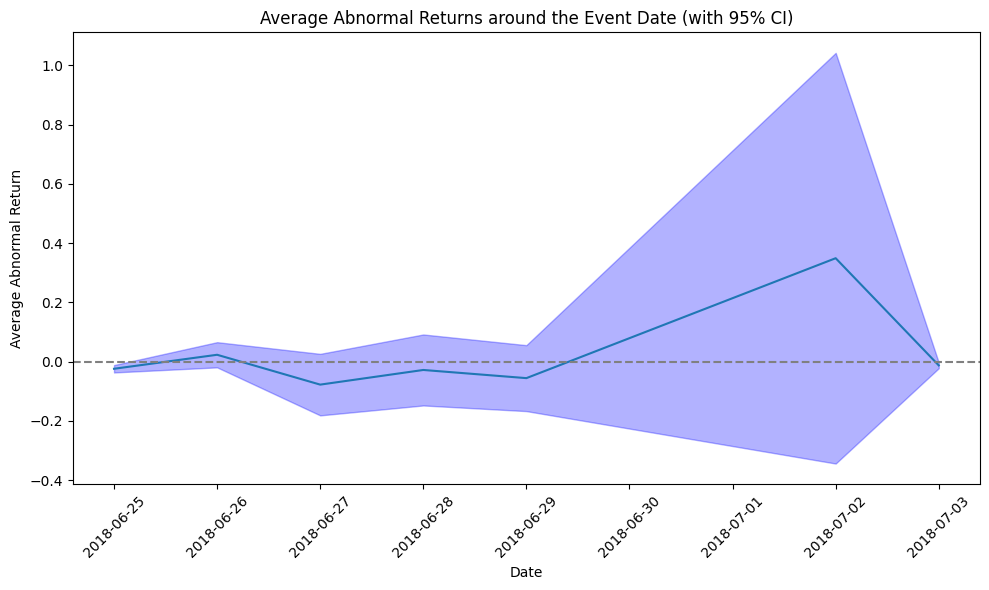

In [46]:



# Group by date and calculate the mean and standard deviation of abnormal returns for each day
daily_stats = event_window_data.groupby('date')['abnormal_return'].agg(['mean', 'std']).reset_index()

# Calculate the number of observations per day
daily_counts = event_window_data.groupby('date')['abnormal_return'].count().reset_index(name='count')


daily_stats = pd.merge(daily_stats, daily_counts, on='date')

# Calculate the standard error of the mean
daily_stats['sem'] = daily_stats['std'] / np.sqrt(daily_stats['count'])

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='mean', data=daily_stats)

# Add shaded region for confidence interval (95% CI)
plt.fill_between(
    daily_stats['date'], 
    daily_stats['mean'] - 1.96 * daily_stats['sem'],  
    daily_stats['mean'] + 1.96 * daily_stats['sem'], 
    color='blue', alpha=0.3
)

plt.axhline(0, color='grey', linestyle='--')  
plt.title('Average Abnormal Returns around the Event Date (with 95% CI)')
plt.xlabel('Date')
plt.ylabel('Average Abnormal Return')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()


In [ ]:

# Define the stock and market index
stock_ticker = 'AAPL'  # Example: Apple Inc.
market_index_ticker = '^GSPC'  # Example: S&P 500

# Define the event date and windows
event_date = datetime(2020, 1, 1)
estimation_window_start = event_date - timedelta(days=365)
estimation_window_end = event_date - timedelta(days=30)
event_window_start = event_date - timedelta(days=10)
event_window_end = event_date + timedelta(days=10)

# Fetch historical data
stock_data = yf.download(stock_ticker, start=estimation_window_start, end=event_window_end)
market_data = yf.download(market_index_ticker, start=estimation_window_start, end=event_window_end)





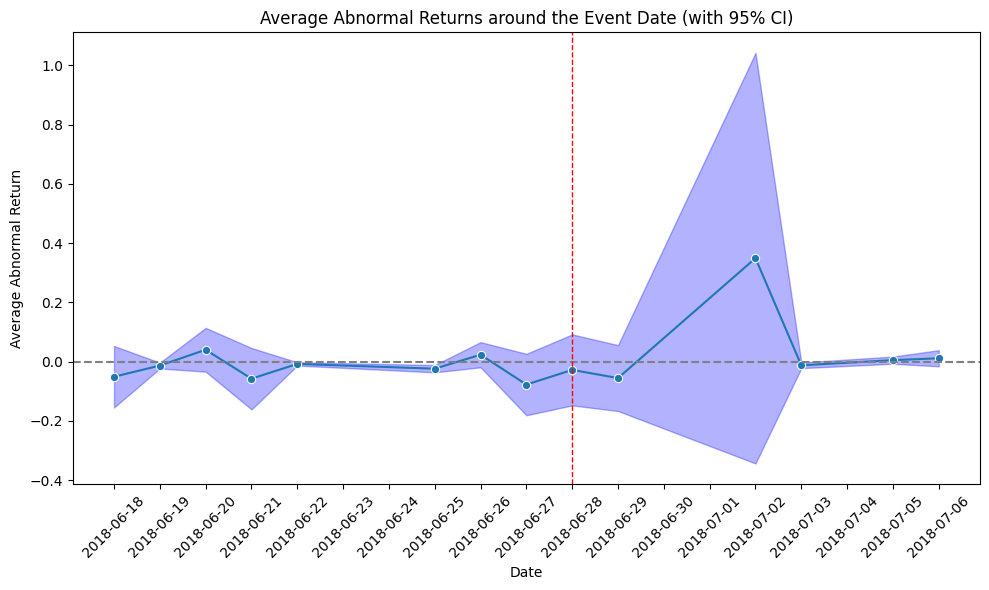

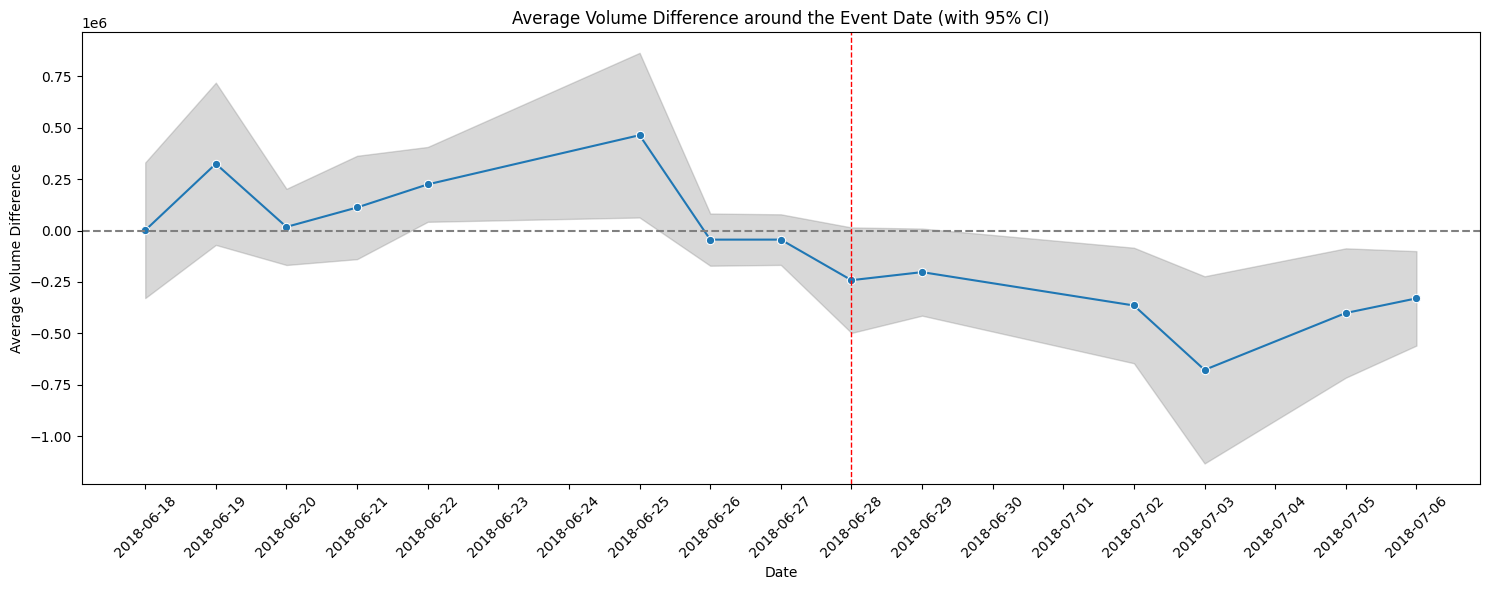

In [112]:
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def event_study(data, study_type, event_date, window_size=10, estimation_window_size=30):
    """
    Performs an event study for either stock price or stock volume.
    """

    # Convert 'date' column to datetime once for efficiency
    data['date'] = pd.to_datetime(data['date'])

    # Define the event and estimation windows
    start_date = event_date - timedelta(days=window_size)
    end_date = event_date + timedelta(days=window_size)
    estimation_start_date = start_date - timedelta(days=estimation_window_size)
    estimation_end_date = start_date - timedelta(days=1)

    # Filter data for the event and estimation windows
    event_window_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].copy()
    estimation_window_data = data[(data['date'] >= estimation_start_date) & (data['date'] <= estimation_end_date)].copy()

    if study_type == 'price':
        # Check if 'market_return' column exists
        if 'market_return' not in data.columns:
            print("Error: 'market_return' column not found in the data.")
            return None

        # Perform event study for stock price
        data['stock_return'] = data.groupby('ticker')['stock_adj_close'].pct_change()
        data['market_return'] = data['market_adj_close'].pct_change()
        parameters = {ticker: estimate_parameters(ticker, data) for ticker in data['ticker'].unique()}
        event_window_data.loc[:, 'expected_return'] = event_window_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)
        event_window_data.loc[:, 'abnormal_return'] = event_window_data['stock_return'] - event_window_data['expected_return']

    elif study_type == 'volume':
        # Perform event study for stock volume
        average_volume_estimation = estimation_window_data.groupby('ticker')['stock_volume'].mean()
        event_window_data = event_window_data.join(average_volume_estimation, on='ticker', rsuffix='_avg')
        event_window_data.loc[:, 'volume_difference'] = event_window_data['stock_volume'] - event_window_data['stock_volume_avg']

    return event_window_data

def plot_event_study(event_window_data, study_type, event_date):
    """
    Plots the results of an event study for stock volume or stock price.
    """
    # Determine the column to use based on study type
    column = 'volume_difference' if study_type == 'volume' else 'abnormal_return'

    # Calculate mean and confidence interval
    grouped_data = event_window_data.groupby('date')[column]
    mean_data = grouped_data.mean()
    sem_data = grouped_data.std() / np.sqrt(grouped_data.count())
    ci = 1.96 * sem_data

    mean_data = mean_data.to_frame('mean')
    mean_data['lower_ci'] = mean_data['mean'] - ci
    mean_data['upper_ci'] = mean_data['mean'] + ci

    # Plotting
    plt.figure(figsize=(15, 6) if study_type == 'volume' else (10, 6))
    plt.fill_between(mean_data.index, mean_data['lower_ci'], mean_data['upper_ci'], color='gray' if study_type == 'volume' else 'blue', alpha=0.3)
    sns.lineplot(data=mean_data, x=mean_data.index, y='mean', marker='o')

    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(mdates.date2num(event_date), color='red', lw=1, ls='--')  # Event date line
    plt.title('Average ' + ('Abnormal Returns' if study_type == 'price' else 'Volume Difference') + ' around the Event Date (with 95% CI)')
    plt.xlabel('Date')
    plt.ylabel('Average ' + ('Abnormal Return' if study_type == 'price' else 'Volume Difference'))
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.tight_layout()
    plt.show()

# Example usage:
event_date = datetime(2018, 6, 28)
# stock_data = pd.read_csv('your_stock_data.csv')  # Load your data

# For stock price event study
price_event_data = event_study(stock_data, 'price', event_date)
plot_event_study(price_event_data, 'price', event_date)

# For stock volume event study
volume_event_data = event_study(stock_data, 'volume', event_date)
plot_event_study(volume_event_data, 'volume', event_date)


In [117]:
path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'
file_name = 'combined_stock_data.csv'
file_path = os.path.join(path, file_name)
stock_data = pd.read_csv(file_path)

def event_study(data, study_type, event_date, group_by, window_size=10, estimation_window_size=30):
    """
    Performs an event study for either stock price or stock volume, grouped by industry, sector, or exchange.
    """
    # Convert 'date' column to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Define event and estimation windows
    start_date = event_date - timedelta(days=window_size)
    end_date = event_date + timedelta(days=window_size)
    estimation_start_date = start_date - timedelta(days=estimation_window_size)
    estimation_end_date = start_date - timedelta(days=1)

    grouped_event_data = []
    for group in data[group_by].unique():
        group_data = data[(data['date'] >= start_date) & (data['date'] <= end_date) & (data[group_by] == group)].copy()
        group_estimation_data = data[(data['date'] >= estimation_start_date) & (data['date'] <= estimation_end_date) & (data[group_by] == group)].copy()

        if study_type == 'price':
            # Perform event study for stock price
            group_data.loc[:, 'stock_return'] = group_data.groupby('ticker')['stock_adj_close'].pct_change()
            group_data.loc[:, 'market_return'] = group_data['market_adj_close'].pct_change()
            parameters = {ticker: estimate_parameters(ticker, group_data) for ticker in group_data['ticker'].unique()}
            group_data.loc[:, 'expected_return'] = group_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)
            group_data.loc[:, 'abnormal_return'] = group_data['stock_return'] - group_data['expected_return']

        elif study_type == 'volume':
            # Perform event study for stock volume
            average_volume_estimation = group_estimation_data.groupby('ticker')['stock_volume'].mean()
            group_data = group_data.join(average_volume_estimation, on='ticker', rsuffix='_avg')
            group_data.loc[:, 'volume_difference'] = group_data['stock_volume'] - group_data['stock_volume_avg']

        grouped_event_data.append(group_data)

    return grouped_event_data


def plot_event_study(grouped_event_data, study_type, event_date, group_by):
    """
    Plots the results of an event study for stock volume or stock price, grouped by industry, sector, or exchange.
    """
    for group_data in grouped_event_data:
        # Determine the column to use based on study type
        column = 'volume_difference' if study_type == 'volume' else 'abnormal_return'

        # Calculate mean and confidence interval
        grouped_data = group_data.groupby('date')[column]
        mean_data = grouped_data.mean()
        sem_data = grouped_data.std() / np.sqrt(grouped_data.count())
        ci = 1.96 * sem_data

        mean_data = mean_data.to_frame('mean')
        mean_data['lower_ci'] = mean_data['mean'] - ci
        mean_data['upper_ci'] = mean_data['mean'] + ci

        # Plotting
        plt.figure(figsize=(15, 6) if study_type == 'volume' else (10, 6))
        plt.fill_between(mean_data.index, mean_data['lower_ci'], mean_data['upper_ci'], color='gray' if study_type == 'volume' else 'blue', alpha=0.3)
        sns.lineplot(data=mean_data, x=mean_data.index, y='mean', marker='o')

        plt.axhline(0, color='grey', linestyle='--')
        plt.axvline(mdates.date2num(event_date), color='red', lw=1, ls='--')  # Event date line
        plt.title(f'Average {("Abnormal Returns" if study_type == "price" else "Volume Difference")} for {group_data[group_by].iloc[0]} around the Event Date (with 95% CI)')
        plt.xlabel('Date')
        plt.ylabel('Average ' + ('Abnormal Return' if study_type == 'price' else 'Volume Difference'))
        plt.xticks(rotation=45)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator())
        plt.tight_layout()
        plt.show()
# Example usage

event_date = datetime(2018, 6, 28)
group_by = 'sector'  # Can be 'industry', 'sector', or 'exchange'

# For stock price event study
grouped_price_event_data = event_study(stock_data, 'price', event_date, group_by)
for group_data in grouped_price_event_data:
    plot_event_study(group_data, 'price', event_date, group_by)

# For stock volume event study
grouped_volume_event_data = event_study(stock_data, 'volume', event_date, group_by)
for group_data in grouped_volume_event_data:
    plot_event_study(group_data, 'volume', event_date, group_by)


ValueError: attempt to get argmax of an empty sequence